In [1]:
import random

In [2]:
from data_process import get_clean_df

In [3]:
clean_df = get_clean_df()

selecting data from db...
data selected
Data Fixing... Search error date
Error type - small: 865
Error type - toomuch: 6


/home/maru/EXT/githubs/quant/data_process.py:105: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[key].fillna(method='ffill', inplace=True)


Data Fixing... Done
Validation... Search error date
Error type - small: 0
Error type - toomuch: 0
Done, 333.38 seconds


In [4]:
import pandas as pd
import time

In [5]:
market_cap_df = pd.read_pickle('market_cap.pkl')

## 중복 날짜 탐색

In [6]:
def get_duplicated_dict(df):
    duplicated_indices = df.groupby('Code').apply(find_duplicates)
    return {code: indices for code, indices in duplicated_indices.items() if indices}

def find_duplicates(group):
    duplicates = group[group.duplicated('yyyymm', keep=False)]
    return duplicates.index.tolist()

In [7]:
duplicated_dict = get_duplicated_dict(market_cap_df)

## drop 할 인덱스 추리기

In [8]:
valid_drop_dict = dict()
for code, indices in duplicated_dict.items():
    valid_drop_dict[code] = {"valid":"", "drop":[]}
    for idx in indices:
        if not valid_drop_dict[code]['valid'] and market_cap_df.iloc[idx]['시가총액']:
            valid_drop_dict[code]['valid'] = idx
        else:
            valid_drop_dict[code]['drop'].append(idx)

In [9]:
drop_indices = []
for _, values in valid_drop_dict.items():
    drop_indices.extend(values['drop'])

## drop

In [10]:
cleaned_market_cap_df = market_cap_df.drop(drop_indices, axis=0)

## 중복되는 date이 더이상 없는지 확인하자

In [11]:
check_dup = get_duplicated_dict(cleaned_market_cap_df)

In [12]:
check_dup

{}

## 피봇

In [13]:
pivot_market_cap_df = cleaned_market_cap_df.pivot(index='yyyymm', columns='Code', values='시가총액')
pivot_market_cap_df = pivot_market_cap_df.fillna(0)

In [14]:
pivot_market_cap_df[:2]

Code,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A950110,A950130,A950140,A950160,A950170,A950180,A950190,A950200,A950210,A950220
yyyymm,,,,,,,,,,,,,,,,,,,,,
200202,3.687409e+12,5.362842e+10,4.782412e+11,3.900840e+09,4.520016e+10,1.329900e+11,2.259622e+11,4.521943e+10,0.0,4.209331e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200203,3.870761e+12,5.642157e+10,4.782412e+11,3.308171e+09,4.113454e+10,1.501500e+11,2.836175e+11,4.534937e+10,0.0,4.001995e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 종목 코드 일치시키기

In [15]:
market_cap_columns = set([c[1:] for c in pivot_market_cap_df.columns])

In [16]:
price_columns = set(list(clean_df.columns))
len(set(price_columns))

2413

In [17]:
market_cap_drop = market_cap_columns - price_columns
columns_to_drop = ['A' + c for c in market_cap_drop]
clean_market_cap_df = pivot_market_cap_df.drop(columns_to_drop, axis=1)

In [18]:
price_df_drop = price_columns - market_cap_columns
clean_price_df = clean_df.drop(price_df_drop, axis=1)

In [19]:
print(len(clean_market_cap_df.columns), len(clean_price_df.columns))

2243 2243


In [20]:
clean_market_cap_df.columns = [col[1:] for col in clean_market_cap_df.columns]

## 백테스팅
- 10분위 시총 값을 얻고 (이것보다 시총이 작으면 해당 날짜에 10분위에 해당함)
- 가격 데이터의 기간을 시총 데이터와 일치시키고
- 가격 데이터의 값을 10분위 인지 아닌지 나타내는 boolean 데이터프레임 생성
- 백테스팅

In [21]:
clean_market_cap_df.index = pd.to_datetime(clean_market_cap_df.index + '01')

In [22]:
clean_market_cap_df[:2]

,000020,000040,000050,000070,000080,000100,000120,000140,000150,000180,...,388790,389030,389140,389260,391710,396300,399720,402340,408920,412350
yyyymm,,,,,,,,,,,,,,,,,,,,,
2002-02-01,5.362842e+10,3.900840e+09,4.520016e+10,2.259622e+11,4.521943e+10,4.209331e+11,9.459100e+10,1.147421e+12,4.786816e+11,1.053000e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-03-01,5.642157e+10,3.308171e+09,4.113454e+10,2.836175e+11,4.534937e+10,4.001995e+11,1.019057e+11,1.438829e+12,4.891790e+11,1.014000e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 17년 10월 결측치를 9월 값으로 취함

In [23]:
if pd.Timestamp('2017-10-01') not in clean_market_cap_df.index:
    clean_market_cap_df.loc[pd.Timestamp('2017-10-01')] = clean_market_cap_df.loc[pd.Timestamp('2017-09-01')]
    clean_market_cap_df.sort_index(inplace=True)

### 날짜별 10분위 시총 값을 얻는다
- 21, 22년도에는 10분위 중 가장 비싼 시총이 600억 정도다. 사실인가?

In [24]:
real_10th_quantile_values_non_zero = clean_market_cap_df.apply(lambda x: x[x > 0].sort_values(ascending=False).iloc[max(int(len(x[x > 0]) * 0.9) - 1, 0)], axis=1)
print(real_10th_quantile_values_non_zero[-10:] / 100000000)

yyyymm
2021-09-01    649.812034
2021-10-01    596.819784
2021-11-01    610.108444
2021-12-01    547.393400
2022-01-01    608.524224
2022-02-01    574.473230
2022-03-01    565.175875
2022-04-01    612.148009
2022-05-01    609.648455
2022-06-01    590.578290
dtype: float64


In [25]:
start_date = clean_market_cap_df.iloc[0].name
end_date = clean_market_cap_df.iloc[-1].name

print(start_date)
print(end_date)

2002-02-01 00:00:00
2022-06-01 00:00:00


### 가격 데이터의 기간을 시총 데이터 기간과 일치하게

In [26]:
filtered_price_df = clean_price_df[(clean_price_df.index >= start_date) & (clean_price_df.index < end_date+pd.DateOffset(months=1))]
filtered_price_df

종목코드,000020,000040,000050,000070,000080,000100,000120,000140,000150,000180,...,388790,389030,389140,389260,391710,396300,399720,402340,408920,412350
날짜,,,,,,,,,,,,,,,,,,,,,
2002-02-01,1920.0,87018.0,2044.0,19825.0,NaN,5890.0,8775.0,33671.0,18328.0,1725.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-04,1900.0,87982.0,1900.0,20336.0,NaN,5843.0,9075.0,32389.0,16922.0,1799.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-05,1962.0,82450.0,1774.0,21307.0,NaN,5843.0,8250.0,32389.0,16881.0,1740.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-06,1980.0,81954.0,1799.0,21818.0,NaN,5946.0,9075.0,35275.0,17042.0,1725.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-07,1882.0,84140.0,1730.0,22482.0,NaN,5935.0,8325.0,40566.0,16721.0,1671.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,9350.0,2154.0,12400.0,74100.0,31600.0,50995.0,112500.0,11400.0,63600.0,1885.0,...,2140.0,4037.0,16600.0,16650.0,2570.0,7310.0,26700.0,40950.0,2307.0,17350.0
2022-06-27,9670.0,2196.0,12300.0,74400.0,31700.0,50628.0,115500.0,11700.0,68200.0,1990.0,...,2140.0,4053.0,17350.0,17000.0,2575.0,7880.0,28100.0,41950.0,2307.0,17400.0
2022-06-28,9820.0,2200.0,12400.0,74900.0,32000.0,51360.0,114500.0,11650.0,70400.0,2010.0,...,2140.0,4354.0,18050.0,17250.0,2605.0,8000.0,29400.0,41400.0,2307.0,17650.0


In [27]:
def is_in_bottom_10_percent(row):
    date = row.name
    month_start = pd.Timestamp(year=date.year, month=date.month, day=1)

    bottom_10_quantile = real_10th_quantile_values_non_zero.loc[month_start]
    market_cap = clean_market_cap_df.loc[month_start]

    is_above_zero = market_cap > 0
    is_below_bottom_10 = market_cap < bottom_10_quantile
    
    return is_above_zero & is_below_bottom_10

is_bottom_10 = filtered_price_df.apply(is_in_bottom_10_percent, axis=1)

## 10분위에 해당하는 종목 갯수는 몇개인가? (100~300개인데, 전체 종목수랑 비교해서도 봐야 할듯)

In [28]:
daily_true_counts = is_bottom_10.sum(axis=1)

In [29]:
daily_true_counts

날짜
2002-02-01     87
2002-02-04     87
2002-02-05     87
2002-02-06     87
2002-02-07     87
             ... 
2022-06-24    224
2022-06-27    224
2022-06-28    224
2022-06-29    224
2022-06-30    224
Length: 5045, dtype: int64

In [30]:
true_code = []
false_code = []

for i, value in is_bottom_10.iloc[0].items():    
    if value:
        true_code.append(i)
    else:
        false_code.append(i)

In [35]:
clean_market_cap_df[random.choice(true_code)]

yyyymm
2002-02-01    1.099080e+10
2002-03-01    1.122300e+10
2002-04-01    1.548000e+10
2002-05-01    1.044900e+10
2002-06-01    9.055800e+09
                  ...     
2022-02-01    1.140189e+11
2022-03-01    1.062073e+11
2022-04-01    1.009495e+11
2022-05-01    9.689352e+10
2022-06-01    1.126669e+11
Name: 012340, Length: 245, dtype: float64

In [33]:
len(true_code)

87

In [34]:
len(false_code)

2156

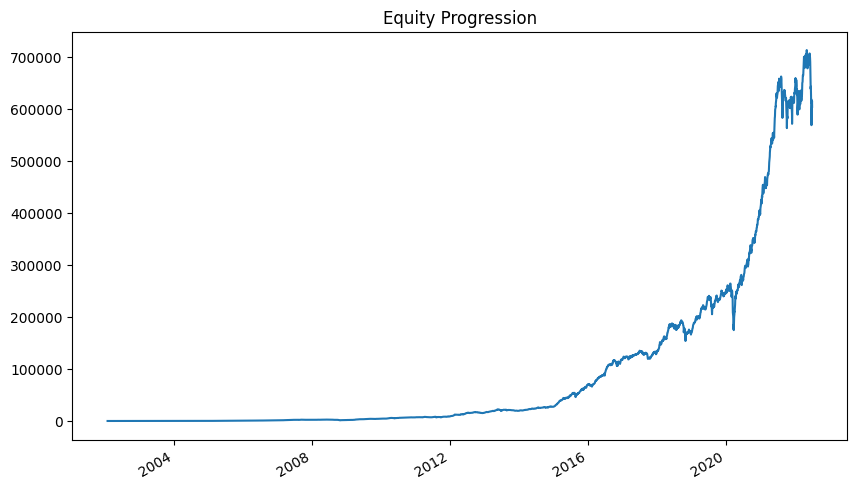

In [36]:
import bt

s = bt.Strategy('10th_small', [bt.algos.SelectWhere(is_bottom_10),
                               bt.algos.WeighEqually(),
                               bt.algos.RunMonthly(),
                               bt.algos.Rebalance()])

backtest = bt.Backtest(s, filtered_price_df)
result = bt.run(backtest)

import matplotlib.pyplot as plt
%matplotlib inline

result.plot(figsize=(10, 6), legend=False)
plt.show()

In [37]:
# result.get_security_weights().head()

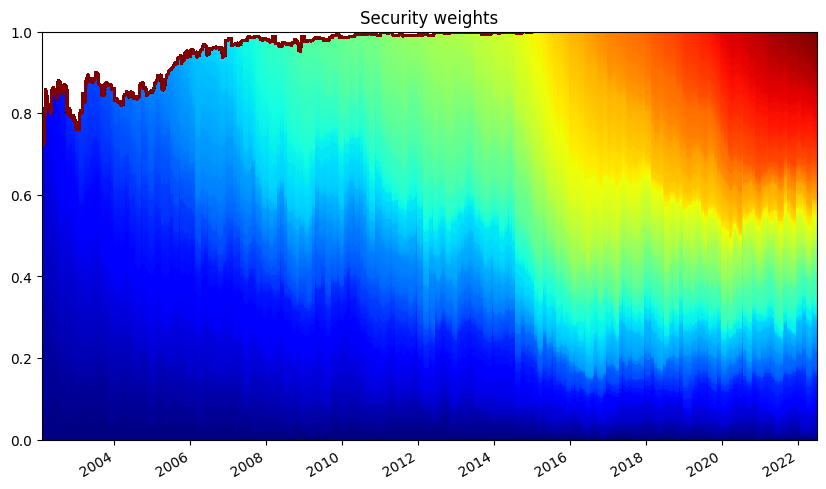

In [38]:
from matplotlib import cm

ax = result.get_security_weights().plot.area(figsize=(10, 6),
                                             ylim=[0, 1],
                                             legend=False,
                                             colormap=cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
# plt.legend(reversed(handles),
#            reversed(labels),
#            loc='lower right',
#            bbox_to_anchor=(1.15, 0))
plt.title("Security weights")
plt.show()

In [39]:
result.display()

Stat                 10th_small
-------------------  ------------
Start                2002-01-31
End                  2022-06-30
Risk-free rate       0.00%

Total Return         603868.29%
Daily Sharpe         2.01
Daily Sortino        3.92
CAGR                 53.20%
Max Drawdown         -49.71%
Calmar Ratio         1.07

MTD                  -13.79%
3m                   -9.68%
6m                   -5.33%
YTD                  -5.33%
1Y                   -4.87%
3Y (ann.)            36.59%
5Y (ann.)            34.93%
10Y (ann.)           44.26%
Since Incep. (ann.)  53.20%

Daily Sharpe         2.01
Daily Sortino        3.92
Daily Mean (ann.)    45.83%
Daily Vol (ann.)     22.83%
Daily Skew           17.73
Daily Kurt           832.32
Best Day             65.24%
Worst Day            -9.40%

Monthly Sharpe       1.73
Monthly Sortino      4.39
Monthly Mean (ann.)  46.73%
Monthly Vol (ann.)   26.95%
Monthly Skew         1.71
Monthly Kurt         15.60
Best Month           64.51%
Worst Month

- 시간은 일치시켰는데, 시총 데이터에 있는 종목이 가격 데이터에는 없는 경우가 있다. A를 떼버리고, 가격 데이터에 없는 column은 is_bottom에서 빼버리자
- 시총 하위 10분위인지 True False 데이터 만들기 (완료)
- 하위 10분위 종목만 매수하는 백테스팅 수행하기 (완료)
- 종목 뽑기 (완료)
- 정리하자 (완료)
- validation

## 매수 종목, 비중 확인...

In [40]:
asset_position = result.get_security_weights()

Timestamp('2004-02-17 00:00:00')

In [41]:
t = asset_position.index[5000]
print(t)

2022-04-25 00:00:00


In [42]:
for code, ratio in asset_position.loc[t][asset_position.loc[t] != 0].items():
    print(code, ratio)

001770 0.00418634065507896
004920 0.0043163341968177026
005030 0.004298644361427248
008290 0.004225405498793655
013000 0.004265663787055494
014910 0.004106999571168805
018500 0.004595723586537646
018680 0.004019574946972171
020400 0.005354358083443432
023790 0.0037860261787929545
025880 0.008435274676154068
026910 0.0042129626545620415
032750 0.003975921301792929
038010 0.0038678632995538184
005110 0.004034759984968309
002420 0.004031042929400412
001420 0.004191360015719483
025870 0.005596450679487179
027040 0.004922251738022342
033790 0.0043734480582107455
054410 0.004360251807228913
043200 0.004443553805773277
045300 0.004412011540323263
053060 0.003940818521636196
060260 0.004317821334998893
039980 0.004302828598115707
065420 0.004373332304142756
065500 0.004225210181755854
032800 0.004366295146163196
033250 0.0053752182303114125
044780 0.004652423117302709
058450 0.004373378261092826
053160 0.004096621199303645
050760 0.004527912814169265
001000 0.004509010146143354
025890 0.004015

In [43]:
for code, ratio in asset_position.iloc[-1][asset_position.iloc[-1] != 0].items():
    print(code, ratio)

001770 0.004290746781701739
002290 0.003940239969962344
004920 0.005684988023877892
008290 0.003937706724387525
010640 0.005048758430613954
012620 0.004207174513473647
013000 0.004150346198936575
014910 0.0036625796978015787
018500 0.004491098690640068
018680 0.003927268759189634
020400 0.004256105890253138
021040 0.004398676288917517
023790 0.004793874188601691
024940 0.0045578824947145715
026910 0.004814439837807459
032750 0.004523596423218051
051630 0.005457203714509974
002420 0.004511839514605193
006920 0.0038495299097910853
001420 0.004436386050086985
025870 0.004285878976479538
030720 0.003709890128556398
027040 0.004421997711936834
033790 0.005197855827566237
035200 0.0037746617409007855
054410 0.004342150142561756
043200 0.004338048933876249
045300 0.003896137323505991
053060 0.004469012762946196
060260 0.004275611881179243
036180 0.004860453842885753
039980 0.004224092620194888
043710 0.0038001495028155874
065420 0.0044434591035321285
032800 0.004359208654005052
033250 0.00405